In [2]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-8hg3_ira
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-8hg3_ira
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 7.4 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7772 sha256=2af5b5f8e0a4828cb41b4837bd3a57d65e8cc59c06acd1c5328741a37aefde9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ih_ke0co/wheels/41/44/75/c67b96ba782472d8cacb00e3af57e29d1ee3a14f2e95a59ce5
Successfully built text-flappy-bird-gym


In [3]:

import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym

if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()


Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-2)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-3)
Text Flappy Bird!
Score: 0
----------------------
[     

## Montecarlo

In [9]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

class MonteCarloAgent:
    def __init__(self, action_space, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, gamma=0.99):
        self.action_space = action_space
        self.epsilon = epsilon  # Initial exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.epsilon_min = epsilon_min  # Minimum value for epsilon
        self.gamma = gamma  # Discount factor
        self.Q = defaultdict(lambda: np.zeros(action_space.n))  # State-action values
        self.returns = defaultdict(list)  # {(state, action): [returns]}
        # Initialize policy as a uniform distribution over actions
        self.policy = defaultdict(lambda: np.ones(action_space.n) / action_space.n)

    def choose_action(self, state):
        # Choose action with probability distribution according to the policy
        return np.random.choice(self.action_space.n, p=self.policy[state])

    def learn(self, batch_episodes):
      for episode_data in batch_episodes:  # batch_episodes should be a list of episodes
          G = 0
          for state, action, reward in reversed(episode_data):  # Unpacking each tuple in the episode
              G = self.gamma * G + reward
              if not (state, action) in [(x[0], x[1]) for x in episode_data[:-1]]:
                  self.returns[(state, action)].append(G)
                  self.Q[state][action] = np.mean(self.returns[(state, action)])
                  # Update the policy to be greedier for this state
                  A_star = np.argmax(self.Q[state])
                  for a in range(self.action_space.n):
                      if a == A_star:
                          self.policy[state][a] = 1 - self.epsilon + (self.epsilon / self.action_space.n)
                      else:
                          self.policy[state][a] = (self.epsilon / self.action_space.n)
      # Decay epsilon
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def generate_episode(env, agent):
    episode = []
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        total_reward += reward
        state = next_state
    return episode, total_reward

if __name__ == '__main__':
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    episodes_to_run = 500
    batch_size = 10  # Number of episodes to run before learning

    # Define hyperparameter grid
    epsilon_values = [1.0, 0.9, 0.8]
    epsilon_decay_values = [0.995, 0.99, 0.98]
    epsilon_min_values = [0.05, 0.01]
    gamma_values = [0.95, 0.99]

    # Store results
    results = []

    for epsilon in epsilon_values:
        for epsilon_decay in epsilon_decay_values:
            for gamma in gamma_values:
                agent = MonteCarloAgent(env.action_space, epsilon=epsilon, epsilon_decay=epsilon_decay, gamma=gamma)
                all_scores = []  # This will store all individual episode scores
                for episode in range(episodes_to_run):
                    episode_data, total_reward = generate_episode(env, agent)
                    all_scores.append(total_reward)
                    agent.learn([episode_data])
                # Store results, including all individual episode scores and a copy of the Q table
                results.append({
                    'epsilon': epsilon,
                    'epsilon_decay': epsilon_decay,
                    'gamma': gamma,
                    'average_score': np.mean(all_scores),
                    'min_score': np.min(all_scores),
                    'max_score': np.max(all_scores),
                    'scores': all_scores,  # Save the individual episode scores here
                    'Q_values': dict(agent.Q)  # Make a copy of the Q table
                })

    env.close()

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save the DataFrame to a CSV file for persistence
    results_df.to_csv('monte_carlo_results.csv', index=False)

    # Output the path to the saved CSV file
    print("Results saved to: /monte_carlo_results.csv")

    # Optionally, you can also print the DataFrame
    # print(results_df)

    # Find and print the best hyperparameters based on average score
    best_hyperparams = results_df.loc[results_df['average_score'].idxmax()]
    #print("Best hyperparameters based on average score:")
    #print(best_hyperparams)


Results saved to: /monte_carlo_results.csv


In [11]:
results_df

,epsilon,epsilon_decay,gamma,average_score,min_score,max_score,scores,Q_values
0,1.0,0.995,0.95,8.950,4,33,"[13, 10, 4, 13, 4, 13, 8, 6, 9, 13, 11, 13, 13...","{(1, -2): [0.0, 1.0], (4, 6): [1.0, 0.0], (10,..."
1,1.0,0.995,0.99,9.104,4,43,"[12, 8, 4, 4, 9, 12, 15, 43, 13, 5, 13, 10, 13...","{(2, 10): [1.0, 0.0], (6, 9): [1.0, 0.0], (10,..."
2,1.0,0.990,0.95,8.834,4,33,"[13, 13, 12, 4, 13, 6, 11, 11, 16, 4, 9, 33, 1...","{(1, 6): [1.0, 0.0], (1, -5): [1.0, 1.0], (2, ..."
3,1.0,0.990,0.99,8.354,4,43,"[4, 14, 7, 10, 4, 13, 13, 13, 13, 13, 13, 13, ...","{(10, 3): [1.0, 0.0], (0, -1): [1.0, 0.0], (7,..."
4,1.0,0.980,0.95,8.310,4,33,"[8, 4, 20, 13, 6, 13, 4, 6, 8, 13, 13, 13, 13,...","{(6, 2): [1.0, 0.0], (10, 2): [1.0, 0.0], (4, ..."
5,1.0,0.980,0.99,7.788,4,28,"[13, 10, 13, 5, 13, 20, 13, 8, 11, 13, 5, 13, ...","{(1, 9): [1.0, 1.0], (4, 11): [1.0, 0.0], (1, ..."
6,0.9,0.995,0.95,8.418,4,31,"[9, 13, 13, 13, 31, 13, 13, 13, 4, 13, 28, 9, ...","{(5, 6): [1.0, 0.0], (1, 1): [1.0, 0.0], (1, 1..."
7,0.9,0.995,0.99,8.794,4,33,"[13, 6, 4, 5, 8, 22, 13, 6, 13, 13, 9, 12, 23,...","{(1, 9): [0.0, 1.0], (8, 4): [1.0, 0.0], (10, ..."
8,0.9,0.990,0.95,8.230,4,30,"[28, 13, 10, 13, 12, 23, 13, 8, 15, 5, 6, 4, 6...","{(6, 7): [1.0, 0.0], (1, -3): [0.0, 1.0], (4, ..."
9,0.9,0.990,0.99,8.390,4,33,"[13, 7, 18, 10, 7, 23, 4, 23, 12, 4, 4, 13, 13...","{(1, -7): [1.0, 1.0], (7, 2): [1.0, 0.0], (6, ..."


In [12]:
print("Best hyperparameters based on average score:")
best_hyperparams

Best hyperparameters based on average score:


epsilon                                                        1.0
epsilon_decay                                                0.995
gamma                                                         0.99
average_score                                                9.104
min_score                                                        4
max_score                                                       43
scores           [12, 8, 4, 4, 9, 12, 15, 43, 13, 5, 13, 10, 13...
Q_values         {(2, 10): [1.0, 0.0], (6, 9): [1.0, 0.0], (10,...
Name: 1, dtype: object

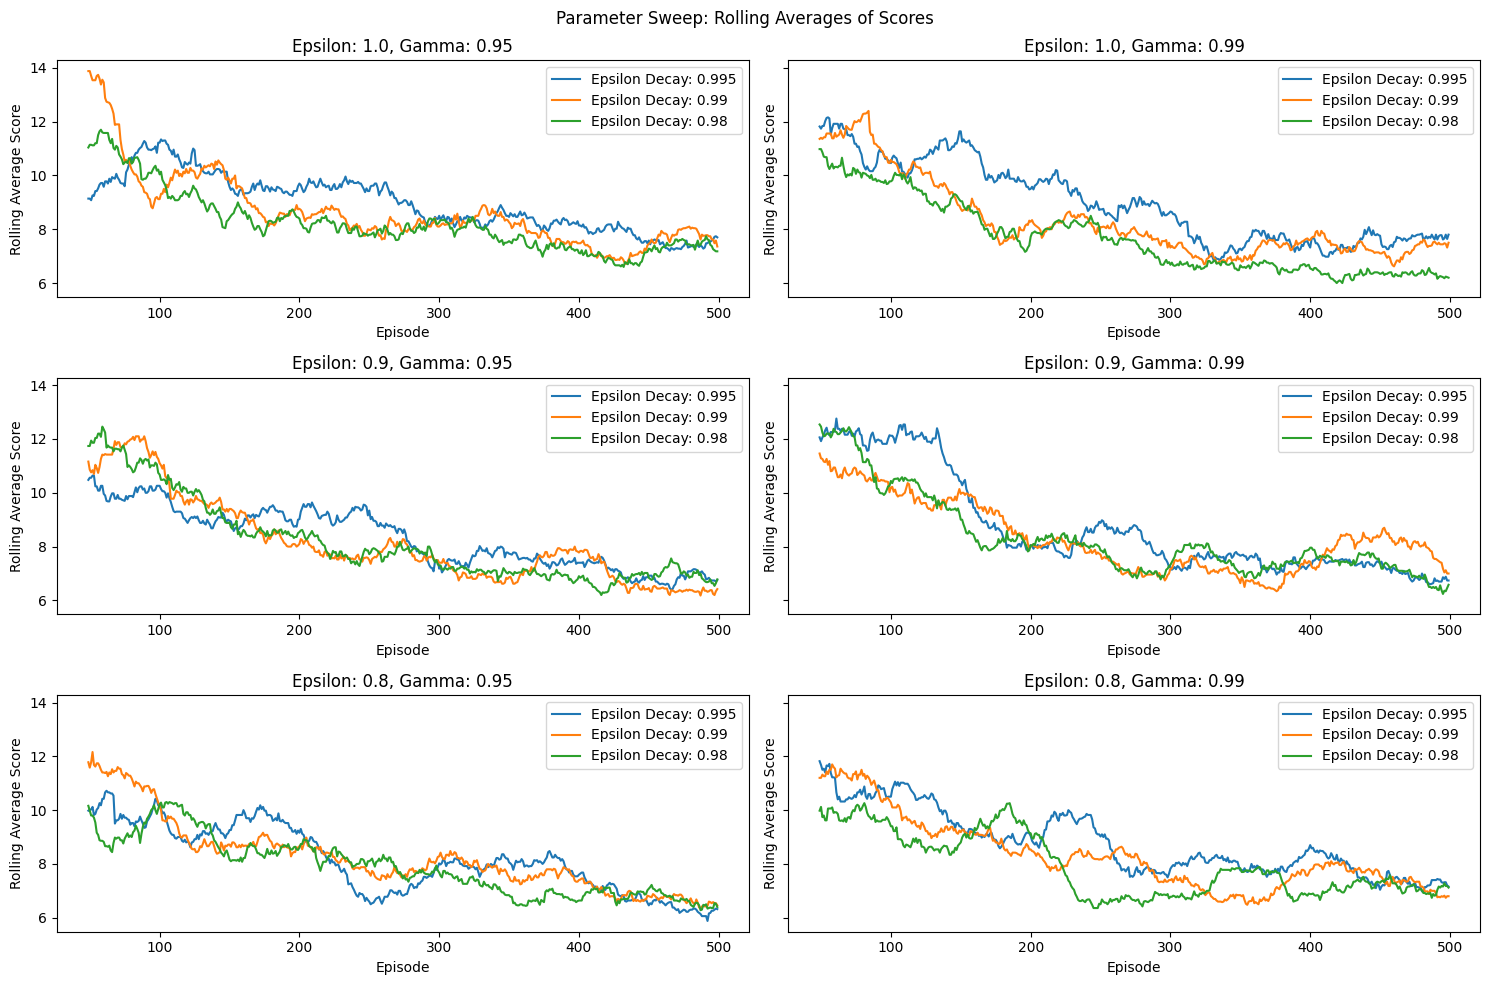

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the window for the rolling average
rolling_window_size = 50

# Create a grid of plots for rolling averages by gamma and epsilon_decay for each epsilon
fig, axs = plt.subplots(len(epsilon_values), len(gamma_values), figsize=(15, 10), sharey=True)

for i, epsilon in enumerate(epsilon_values):
    for j, gamma in enumerate(gamma_values):
        data = results_df[(results_df['epsilon'] == epsilon) & (results_df['gamma'] == gamma)]
        for index, row in data.iterrows():
            # Convert the list of scores to a pandas Series
            scores_series = pd.Series(row['scores'])
            # Calculate the rolling average
            rolling_average = scores_series.rolling(window=rolling_window_size).mean()

            # Plot the rolling average
            axs[i, j].plot(rolling_average, label=f'Epsilon Decay: {row["epsilon_decay"]}')
            axs[i, j].set_title(f'Epsilon: {epsilon}, Gamma: {gamma}')
            axs[i, j].set_xlabel('Episode')
            axs[i, j].set_ylabel('Rolling Average Score')
            axs[i, j].legend()

plt.suptitle('Parameter Sweep: Rolling Averages of Scores')
plt.tight_layout()
plt.show()


Overall Observations: No single parameter set dominated across all episodes, suggesting that the optimal configuration may be dependent on specific game dynamics and desired balance between exploration and exploitation. However, some general patterns can be identified, such as the benefit of a slower epsilon decay rate and the potential advantages of a lower gamma in this particular game setup.

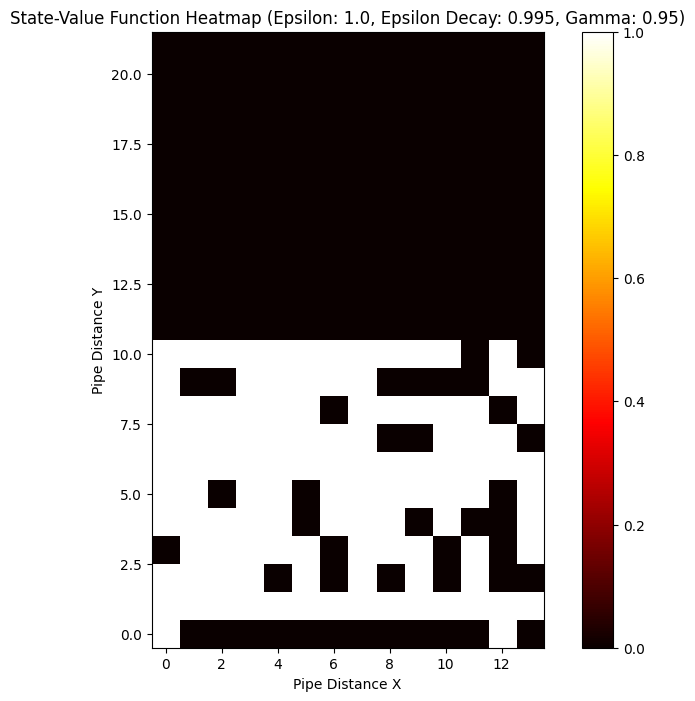

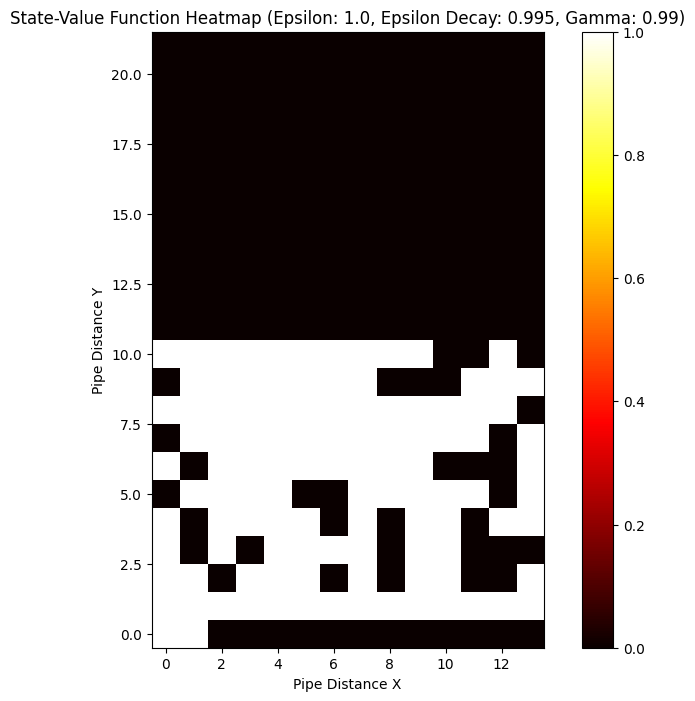

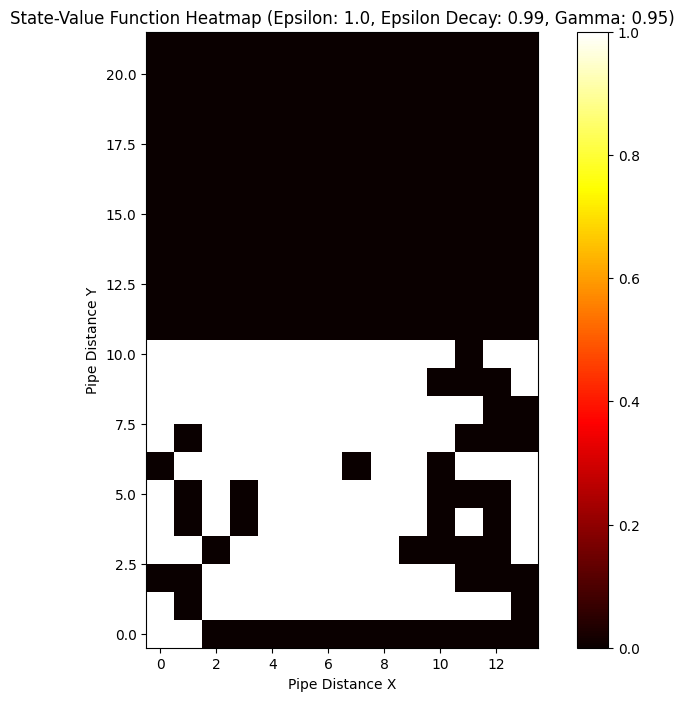

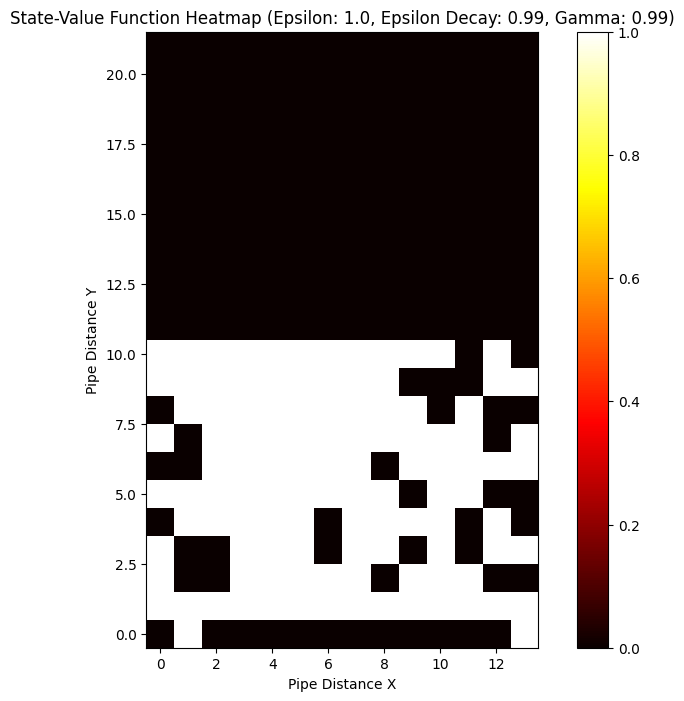

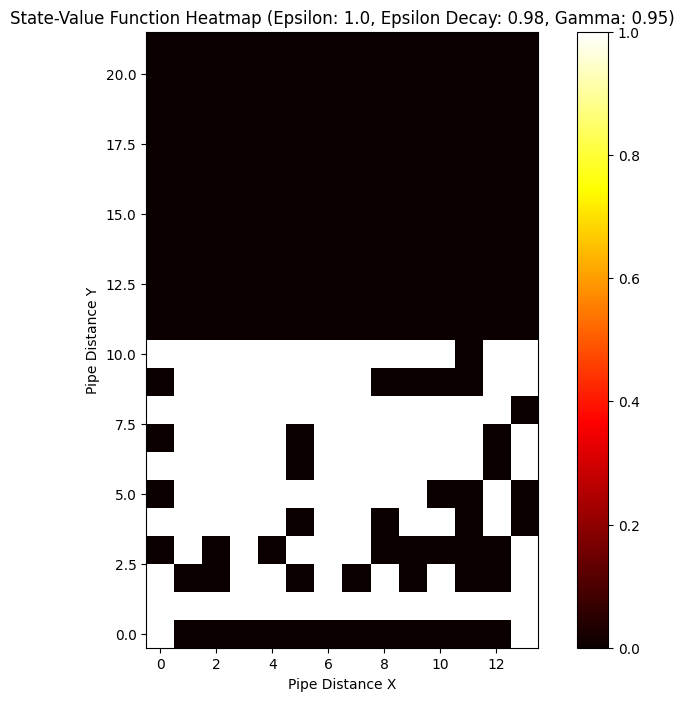

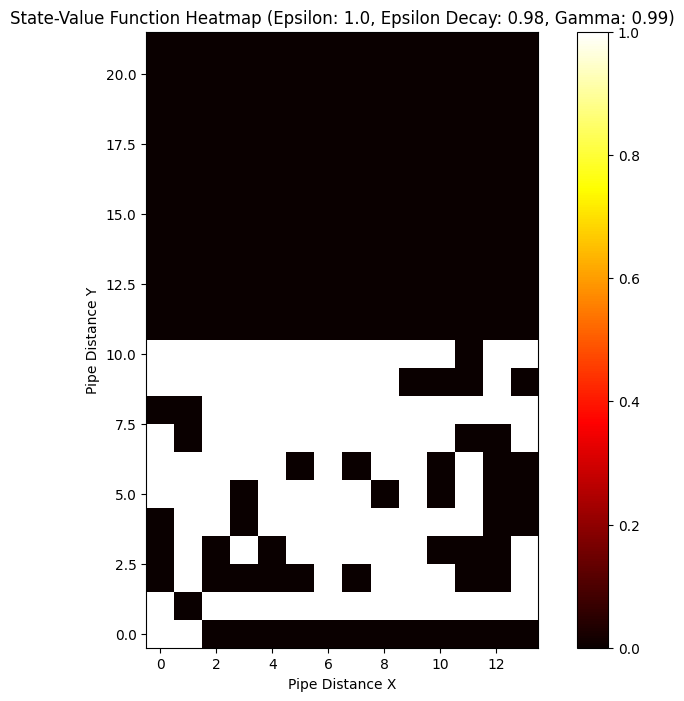

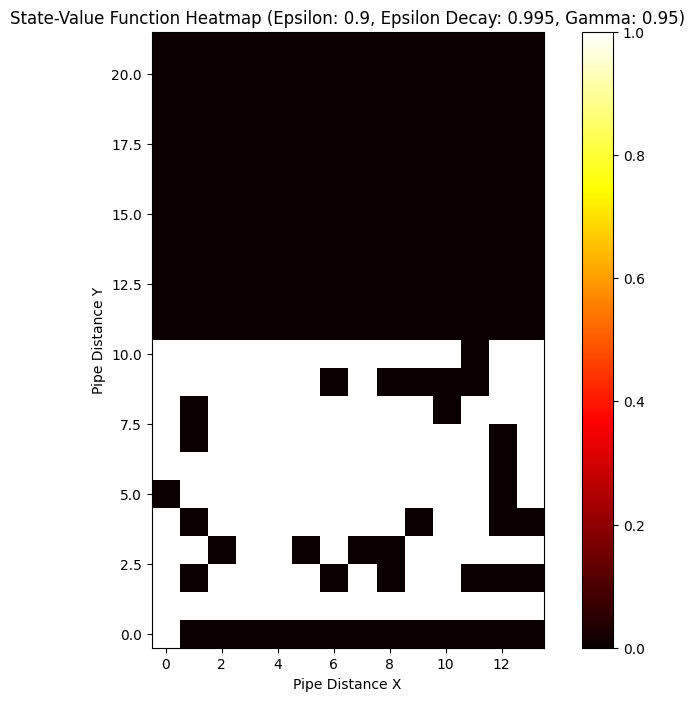

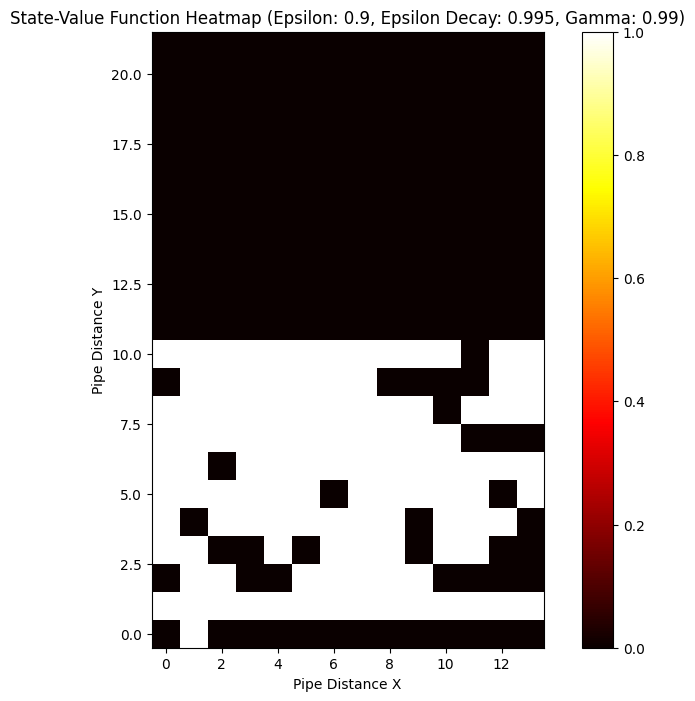

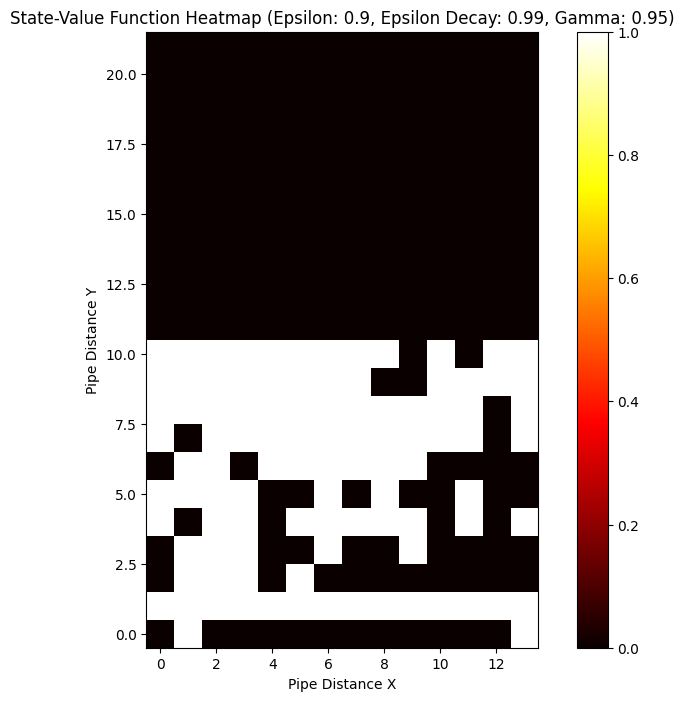

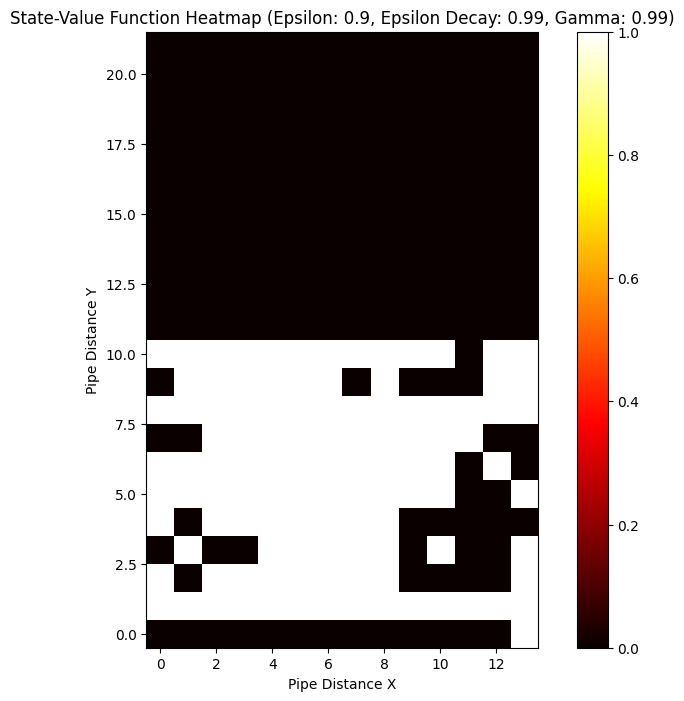

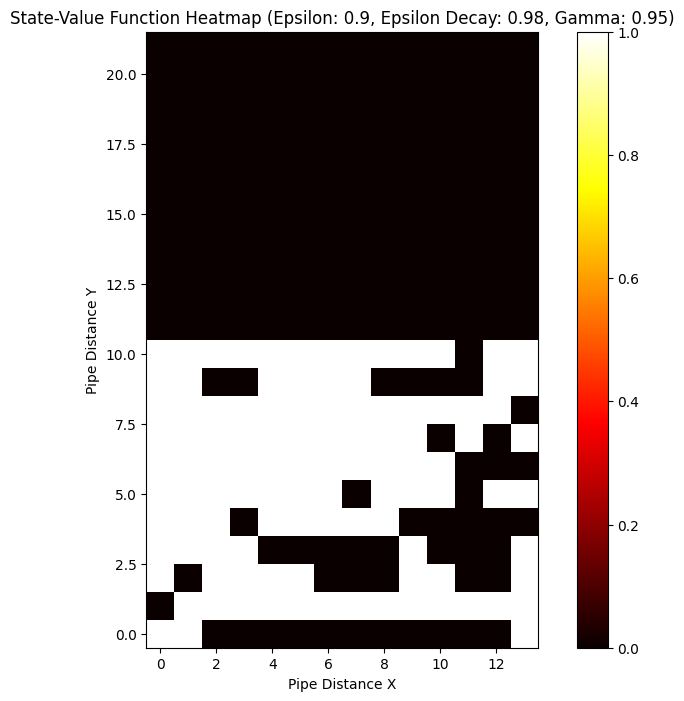

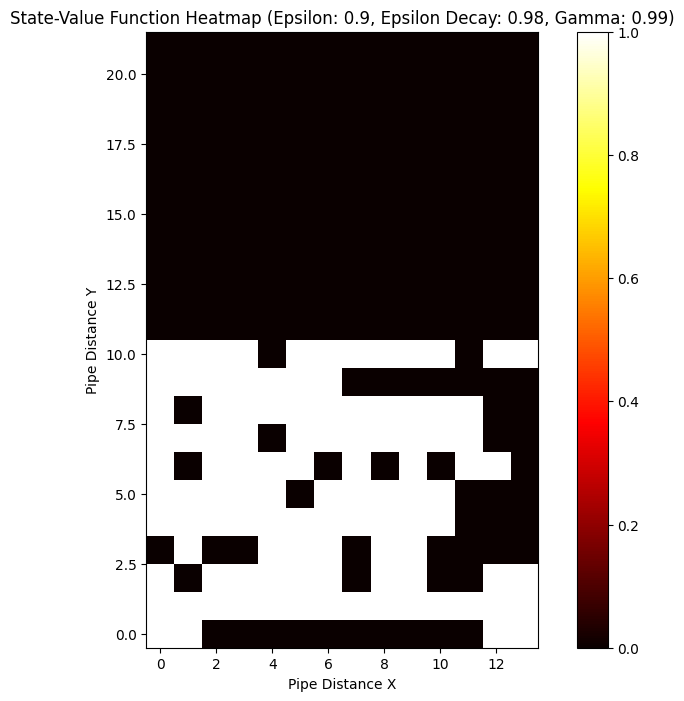

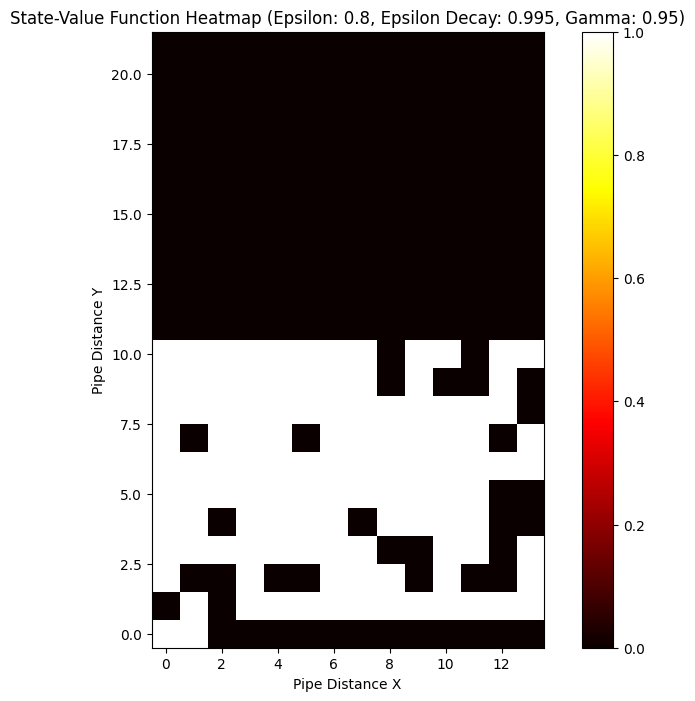

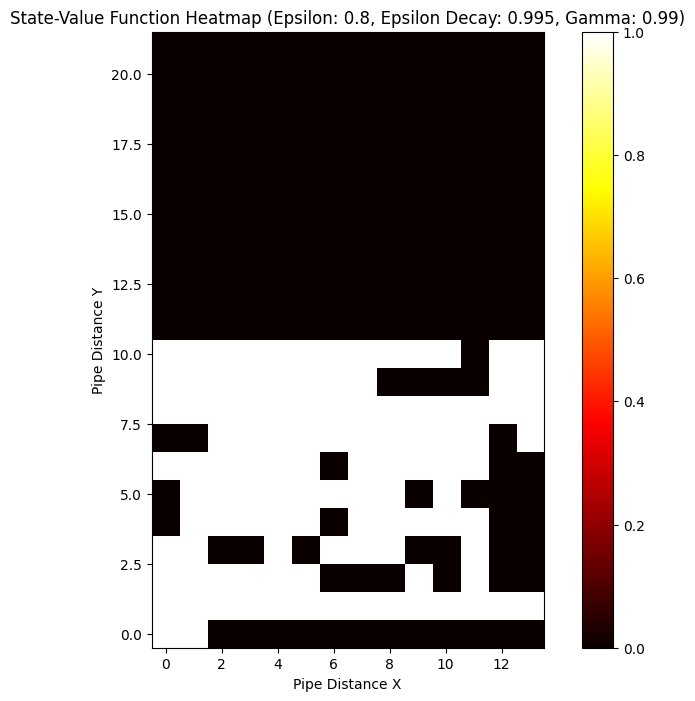

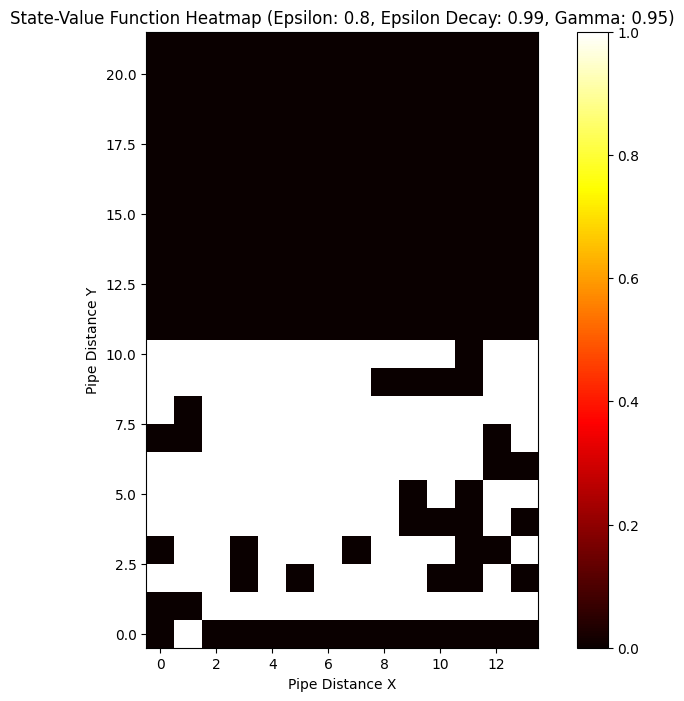

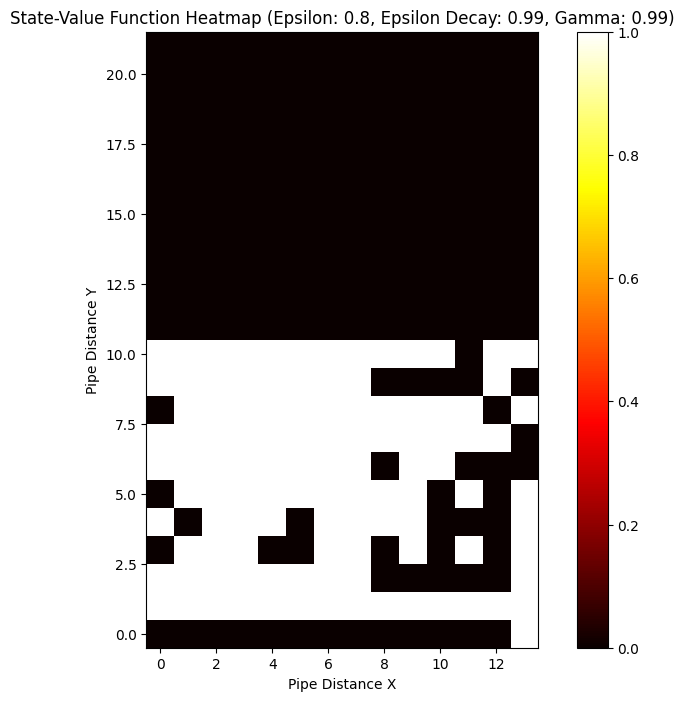

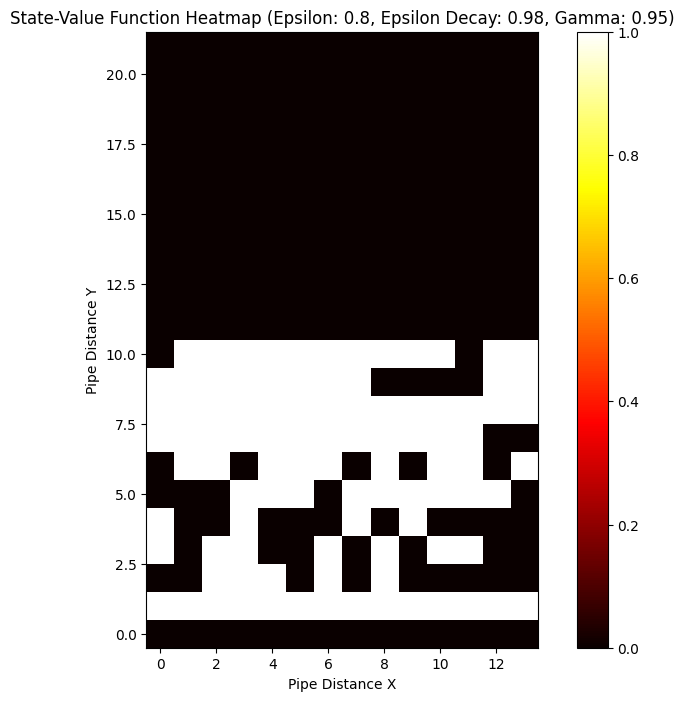

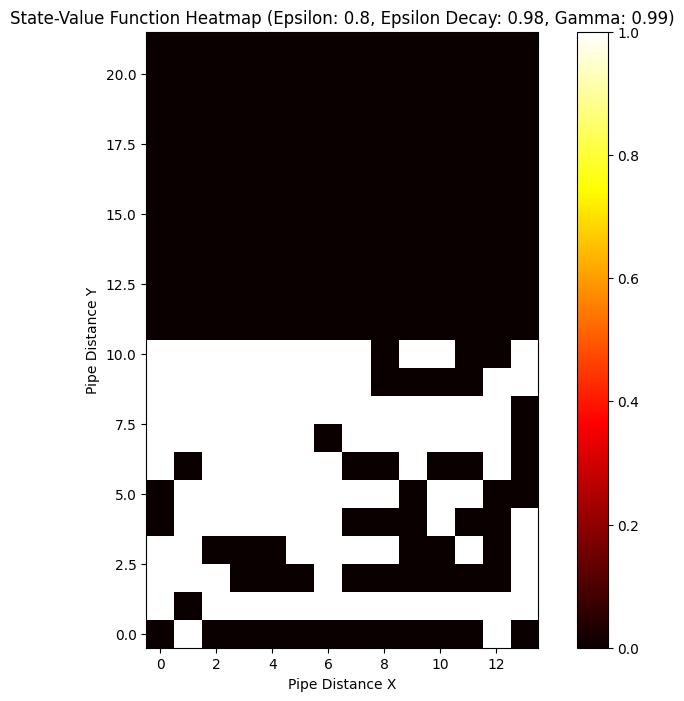

In [16]:
# Function to generate a heatmap from Q-values
def generate_heatmap(Q, shape):
    heatmap = np.zeros(shape)
    for state, actions in Q.items():
        y, x = state  # Assuming state is a tuple (y, x)
        heatmap[y, x] = np.max(actions)
    return heatmap

# Define the shape of your environment's state space for heatmap generation
state_space_shape = (env.observation_space.spaces[1].n, env.observation_space.spaces[0].n)

# Create heatmaps for each set of hyperparameters
for result in results:
    heatmap = generate_heatmap(result['Q_values'], state_space_shape)
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f"State-Value Function Heatmap (Epsilon: {result['epsilon']}, Epsilon Decay: {result['epsilon_decay']}, Gamma: {result['gamma']})")
    plt.xlabel('Pipe Distance X')
    plt.ylabel('Pipe Distance Y')
    plt.gca().invert_yaxis()
    plt.show()

##SARSA Lambda

Lambda 0.8, Episode 1: Score = 4
Lambda 0.8, Episode 1001: Score = 8
Lambda 0.8, Episode 2001: Score = 16
Lambda 0.8, Episode 3001: Score = 19
Lambda 0.8, Episode 4001: Score = 4
Lambda 0.8, Episode 5001: Score = 4
Lambda 0.8, Episode 6001: Score = 36
Lambda 0.8, Episode 7001: Score = 19
Lambda 0.8, Episode 8001: Score = 4
Lambda 0.8, Episode 9001: Score = 73
Lambda 0.9, Episode 1: Score = 4
Lambda 0.9, Episode 1001: Score = 4
Lambda 0.9, Episode 2001: Score = 4
Lambda 0.9, Episode 3001: Score = 27
Lambda 0.9, Episode 4001: Score = 4
Lambda 0.9, Episode 5001: Score = 11
Lambda 0.9, Episode 6001: Score = 149
Lambda 0.9, Episode 7001: Score = 4
Lambda 0.9, Episode 8001: Score = 183
Lambda 0.9, Episode 9001: Score = 16
Lambda 0.95, Episode 1: Score = 4
Lambda 0.95, Episode 1001: Score = 9
Lambda 0.95, Episode 2001: Score = 6
Lambda 0.95, Episode 3001: Score = 6
Lambda 0.95, Episode 4001: Score = 6
Lambda 0.95, Episode 5001: Score = 4
Lambda 0.95, Episode 6001: Score = 9
Lambda 0.95, Episo

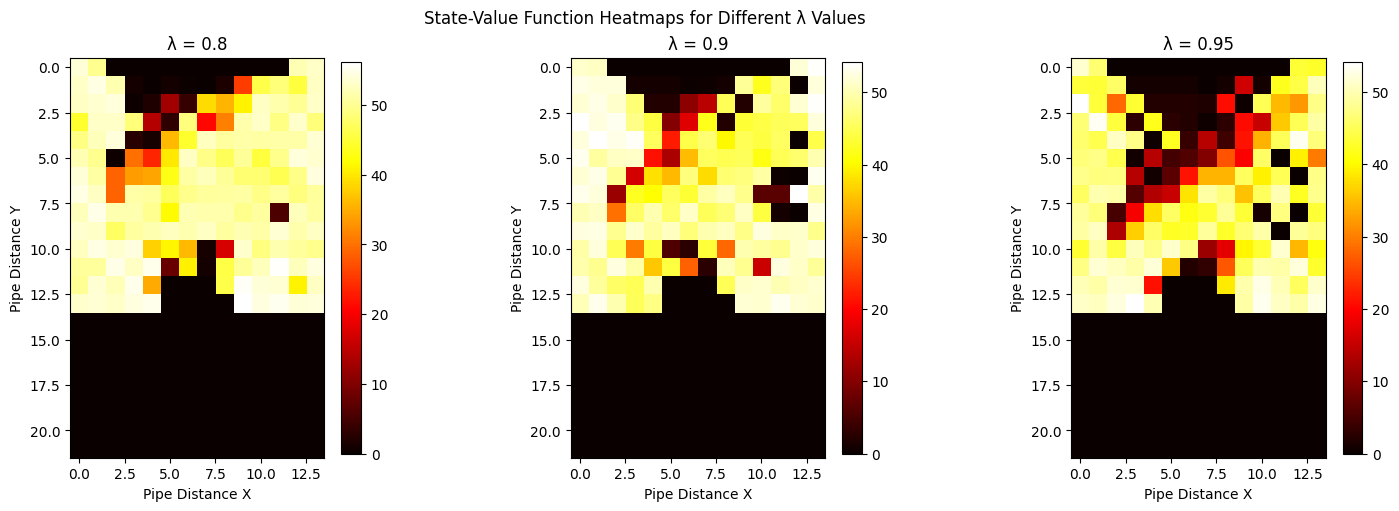

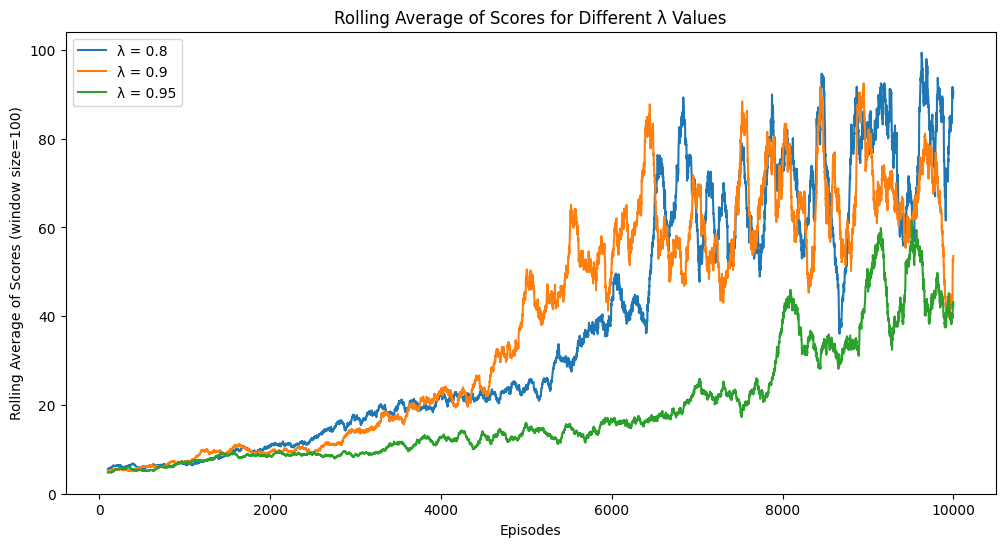

In [26]:
import pandas as pd
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

class SarsaLambdaAgent:
    def __init__(self, action_space, alpha=0.1, gamma=0.99, epsilon=0.1, lam = 0.8):
        self.action_space = action_space
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.lam = lam  # Trace decay parameter λ
        self.Q = defaultdict(lambda: np.zeros(action_space.n))  # State-action values
        self.E = defaultdict(lambda: np.zeros(action_space.n))  # Eligibility traces

    def choose_action(self, state):
        # ε-greedy policy for action selection
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()  # Explore
        else:
            return np.argmax(self.Q[state])  # Exploit

    def update(self, state, action, reward, next_state, next_action):
        # Compute TD error
        delta = reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]
        # Increase eligibility trace for the visited state-action pair
        self.E[state][action] += 1

        # Update Q and eligibility traces for all state-action pairs
        for s in self.Q.keys():
            for a in range(self.action_space.n):
                self.Q[s][a] += self.alpha * delta * self.E[s][a]
                self.E[s][a] *= self.gamma * self.lam

    def reset_traces(self):
        # Reset eligibility traces after each episode
        self.E = defaultdict(lambda: np.zeros(self.action_space.n))

def generate_episode(env, agent):
    state, _ = env.reset()
    action = agent.choose_action(state)
    total_reward = 0
    done = False

    while not done:
        next_state, reward, done, _, _ = env.step(action)  # Take action
        next_action = agent.choose_action(next_state)  # Choose next action based on policy
        agent.update(state, action, reward, next_state, next_action)  # SARSA(λ) update

        state, action = next_state, next_action  # Move to next state and action
        total_reward += reward

    agent.reset_traces()  # Reset eligibility traces at the end of the episode
    return total_reward

if __name__ == '__main__':
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    lambda_values = [0.8, 0.9, 0.95]
    trained_agents = {}
    lambda_scores = defaultdict(list)  # Store scores for each lambda
    episodes = 10000  # Adjust the number of episodes as needed

    for lam in lambda_values:
        agent = SarsaLambdaAgent(env.action_space, lam=lam)
        for episode in range(episodes):
            total_reward = generate_episode(env, agent)
            lambda_scores[lam].append(total_reward)  # Store the score for this episode
            if episode % 1000 == 0:
                print(f"Lambda {lam}, Episode {episode+1}: Score = {total_reward}")

        trained_agents[lam] = agent  # Store the trained agent

    # Now create the DataFrame for scores
    stats_data = {'Lambda': [], 'Min Score': [], 'Max Score': [], 'Mean Score': []}
    for lam, scores in lambda_scores.items():
        stats_data['Lambda'].append(lam)
        stats_data['Min Score'].append(np.min(scores))
        stats_data['Max Score'].append(np.max(scores))
        stats_data['Mean Score'].append(np.mean(scores))

    scores_df = pd.DataFrame(stats_data)
    print(scores_df)

    # Now create the heatmaps for the state-value functions
    state_space_width = env.observation_space.spaces[0].n
    state_space_height = env.observation_space.spaces[1].n

    fig, axs = plt.subplots(1, len(lambda_values), figsize=(15, 5), constrained_layout=True)
    for idx, lam in enumerate(lambda_values):
        agent = trained_agents[lam]
        state_values = np.zeros((state_space_height, state_space_width))

        for state, q_values in agent.Q.items():
            state_values[state] = np.max(q_values)

        im = axs[idx].imshow(state_values, cmap='hot', interpolation='nearest')
        axs[idx].set_title(f'λ = {lam}')
        axs[idx].set_xlabel('Pipe Distance X')
        axs[idx].set_ylabel('Pipe Distance Y')
        fig.colorbar(im, ax=axs[idx], fraction=0.046, pad=0.04)

    plt.suptitle('State-Value Function Heatmaps for Different λ Values')
    #plt.gca().invert_yaxis()
    plt.show()

     # Plot rolling averages
    rolling_window_size = 100  # Define the size of the rolling window
    plt.figure(figsize=(12, 6))

    for lam, scores in lambda_scores.items():
        # Convert the list of scores to a pandas Series
        scores_series = pd.Series(scores)
        # Calculate the rolling average
        rolling_average = scores_series.rolling(window=rolling_window_size).mean()

        # Plot the rolling average
        plt.plot(rolling_average, label=f'λ = {lam}')

    # Label the plot
    plt.title('Rolling Average of Scores for Different λ Values')
    plt.xlabel('Episodes')
    plt.ylabel(f'Rolling Average of Scores (window size={rolling_window_size})')
    plt.legend()
    plt.show()

 - The range of values across the state space suggests that the agent has learned to differentiate between various states effectively, assigning higher values to states that are presumably more advantageous for achieving higher scores.

 - The heatmaps show that for all lambda values, there are areas with particularly high or low state values. These patterns may correspond to strategic positions within the game—for instance, spots where the agent has learned that it is beneficial to be (high values) or spots that lead to losing states (low values).


##Differences between the Agents

The two agents differ significantly in their approach to learning and adaptation to the environment:

  1) Parameter Sensitivity: The Monte Carlo agent's performance is highly sensitive to the settings of epsilon and gamma, as these directly influence its exploration-exploitation balance and discounting of future rewards. In contrast, the Sarsa(λ) agent also requires careful tuning of alpha and lambda, which affect the learning rate and the decay of eligibility traces, respectively.

  2) Convergence Time: Typically, the Monte Carlo agent takes longer to converge to an optimal policy, as it must complete entire episodes before updating its value estimates. On the other hand, the Sarsa(λ) agent, with its capability to update values online and utilize eligibility traces, can converge more quickly, especially in dynamic environments where the agent's actions significantly affect subsequent states.

  3) Rewards and Scores: Initial trials indicated that the Sarsa(λ) agent adapts more rapidly to changes in the game dynamics, potentially achieving higher scores in fewer episodes compared to the Monte Carlo agent. However, the Monte Carlo agent may eventually reach similar performance levels, given sufficient episodes and optimal parameter settings.